# GEOS 518: Applied Hydrologic Modeling

## Problem Set 2: Autoregressive Models

In this Jupyter notebook, you will complete the following tasks with your time series of choice


#### 1. Read in the dataset and perform any additional pre-processing needed



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as sm
from pandas.core import datetools

# Load the Arrowrock Reservoir Elevation dataset
df = pd.read_csv('ArrowrockReservoirElevation.csv', names=['Elevation','Y','M','D'], skiprows=1) #read in csv with Elevation data
df['SerDates'] = pd.to_datetime(df.Y*10000+df.M*100+df.D,format='%Y%m%d') #Define the datetime format

# Create a Water Year column for our pandas data frame. This is a pretty 
# simple thing to do, but may not be necessary if you're not dealing with
# discharge data. Here's how it goes:
# 1. Create an empty array that is full of zeros and equal in length to 
#    the number of days in the record
WY = np.zeros(len(df['Y'].index)) 
# 2. For those records where the month is less than 10, their associated 
#    year is the correct water year
WY[df['M'].values < 10] = df['Y'].values[df['M'].values < 10] 
# 3. For those records where the month is greater than or equal to 10, 
#    the correct water year is one more than the current calendar year
WY[df['M'].values >= 10] = df['Y'].values[df['M'].values >= 10] + 1
# 4. Save the water year array as a column in the pandas data frame, as an
#    integer
df['WY'] = WY.astype(int)

# Print the first and last 10 records just to make sure we loaded the data okay
qrows = np.concatenate([np.arange(0,10,1),np.arange(-11,-1,1)])
df.iloc[qrows,:]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  """


,Elevation,Y,M,D,SerDates,WY
0,3130.27,2006,10,1,2006-10-01,2007
1,3131.10,2006,10,2,2006-10-02,2007
2,3131.94,2006,10,3,2006-10-03,2007
3,3132.78,2006,10,4,2006-10-04,2007
4,3133.68,2006,10,5,2006-10-05,2007
5,3134.54,2006,10,6,2006-10-06,2007
6,3135.41,2006,10,7,2006-10-07,2007
7,3136.32,2006,10,8,2006-10-08,2007
8,3137.17,2006,10,9,2006-10-09,2007
9,3138.02,2006,10,10,2006-10-10,2007


#### 2. Split the dataset into a "training" dataset used to estimate the parameters of the AR mode, and a "test" dataset against which you will test the model

In [2]:
# In the following example, we're going to segment the whole dataframe
# into a training dataset (everything that's not Water Year 2015) and
# a test dataset (everything that is Water Year 2015).
df_train = df[df.WY != 2015]
df_test  = df[df.WY == 2015]

#### 3. Estimate the parameters of an AR(1) model using the training dataset
    * Compute the autocorrelation function
    * Use Yule-Walker equations to estimate the AR(1) parameters
    * Use the statsmodel AR tools to estimate the parameters based on the dataset
    * Compare the YW parameters to those from the statsmodel library

In [3]:
# Compute the autocorrelation function with first lag
E = df['Elevation'].values
Et   = E[1:-1] 
Etm1 = E[0:-2]
R1 = np.corrcoef(Etm1,Et)
print(R1[1,0])

0.999560918574


In [4]:
# Compute the autocorrelation function with second lag
Et   = E[2:-1] 
Etm2 = E[0:-3]
R2 = np.corrcoef(Etm2,Et)
print(R2[1,0])

0.998291414052


In [19]:
# Compute the AR(1) parameter using the Yule-Walker Equation
rho1 = 0.99956
rho2 = 0.99829
AR1_phi = rho1
print(AR1_phi)

0.99956


In [5]:
# Compute the YW parameters using the statsmodel library
Et = pd.Series(df_train['Elevation'].values,df_train['SerDates'].values)
E_AR1_model = sm.AR(Et).fit(1)
print(E_AR1_model.params)

const    1.537085
L1.y     0.999516
dtype: float64


#### The YW parameter calculated for the AR(1) model is very similar to the one estimated using the statsmodel library. 

#### 4. Estimate the parameters of an AR(2) model using the training dataset
    * Use Yule-Walker equations to estimate the AR(2) parameters
    * Use the statsmodel AR tools to estimate the parameters based on the dataset
    * Compare the YW parameters to those from the statsmodel library


In [20]:
# Compute the AR(2) parameters using the Yule-Walker Equations
phi1 = (1-(((rho1*rho1)-rho2)/((rho1*rho1)-1)))*rho1
phi2 = ((rho1*rho1)-rho2)/((rho1*rho1)-1)
print(phi1,phi2)

1.9427542241111975 -0.9436094122525887


In [6]:
# Compute the YW parameters using the statsmodel library
Et = pd.Series(df_train['Elevation'].values,df_train['SerDates'].values)
E_AR1_model = sm.AR(Et).fit(2)
print(E_AR1_model.params)

const    2.858975
L1.y     1.943585
L2.y    -0.944485
dtype: float64


#### 5. Apply the AR(1) and AR(2) models to the "test" dataset (the one withheld from parameter estimation)


In [7]:
#Compute the AR(1) YW parameters using statsmodel for the test dataset
Et_test = pd.Series(df_test['Elevation'].values,df_test['SerDates'].values)
E_AR1_model_t = sm.AR(Et_test).fit(1)
print(E_AR1_model_t.params)

const   -1.917904
L1.y     1.000597
dtype: float64


In [8]:
#Compute the AR(2) YW parameters using statsmodel for the test dataset
Et_test = pd.Series(df_test['Elevation'].values,df_test['SerDates'].values)
E_AR2_model_t = sm.AR(Et_test).fit(2)
print(E_AR2_model_t.params)

const    1.558050
L1.y     1.950158
L2.y    -0.950649
dtype: float64


#### 6. Plot the modeled time series for the AR(1) and AR(2) models against the observed time series for comparison


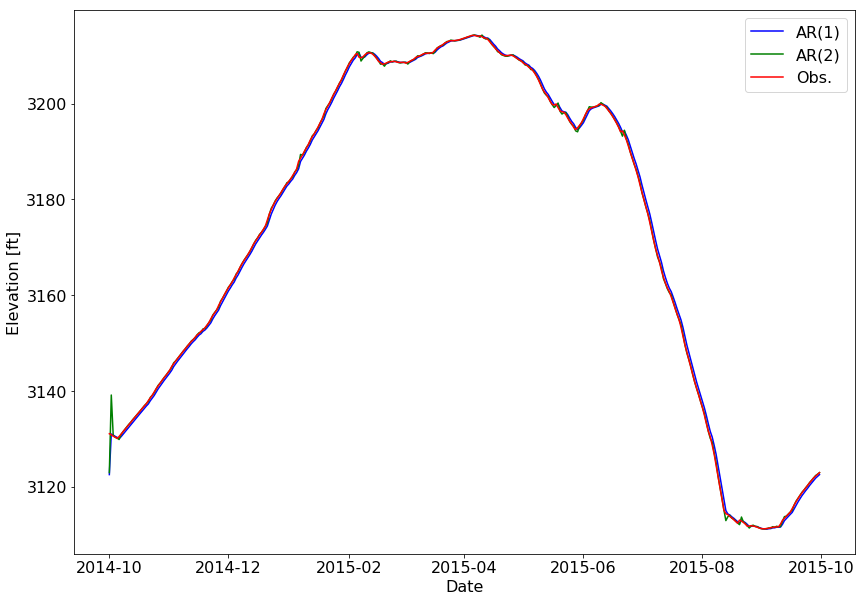

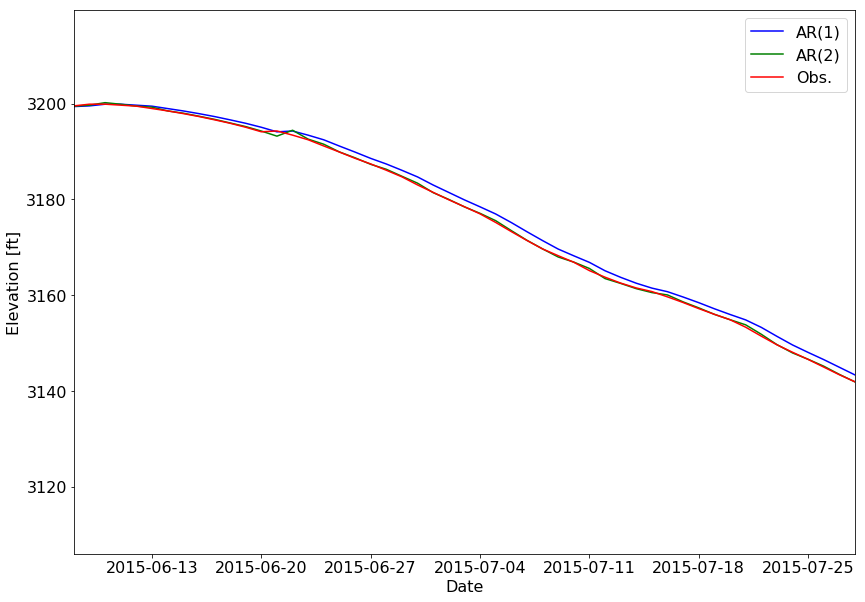

In [9]:
#Create variables for the 1 and 2 lag elevations
Ettm1 = np.concatenate([Et_test[-2:-1],Et_test[0:-1]])
Ettm2 = np.concatenate([Et_test[-3:-1],Et_test[0:-2]])

DatesTest = df_test['SerDates'].values

AR1_mu   = E_AR1_model_t.params[0]
AR1_phi1 = E_AR1_model_t.params[1]

EhatAR1 = AR1_mu + AR1_phi1*Ettm1

AR2_mu   = E_AR2_model_t.params[0]
AR2_phi1 = E_AR2_model_t.params[1]
AR2_phi2 = E_AR2_model_t.params[2]

EhatAR2 = AR2_mu + AR2_phi1*Ettm1 + AR2_phi2*Ettm2

plt.figure(figsize=(14,10))

plt.plot(DatesTest,EhatAR1,'b-')
plt.plot(DatesTest,EhatAR2,'g-')
plt.plot(DatesTest,Et_test,'r-')
plt.ylabel('Elevation [ft]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

plt.figure(figsize=(14,10))
plt.plot(DatesTest,EhatAR1,'b-')
plt.plot(DatesTest,EhatAR2,'g-')
plt.plot(DatesTest,Et_test,'r-')
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('Elevation [ft]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

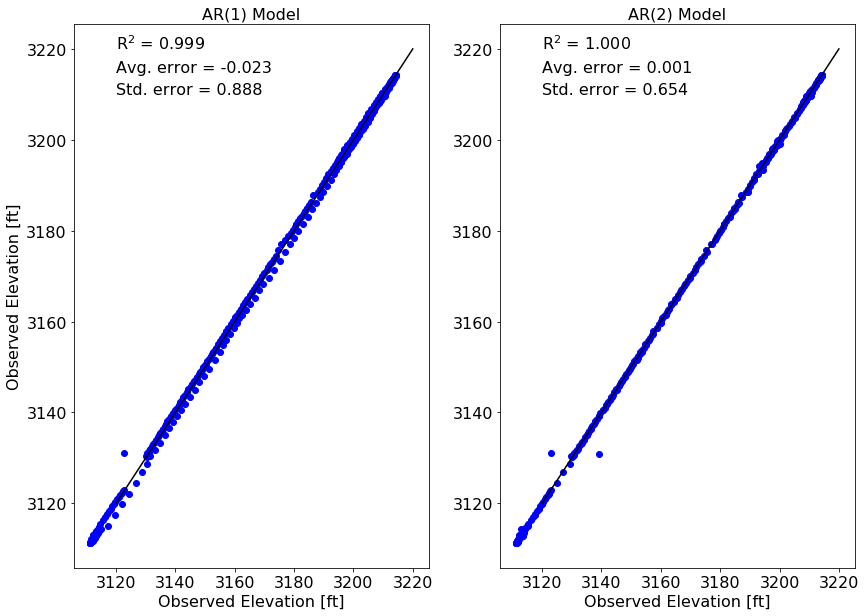

In [10]:
# Compute the R^2 values for each prediction 
R2AR1  = np.corrcoef(EhatAR1,Et_test)**2
R2AR2  = np.corrcoef(EhatAR2,Et_test)**2
muAR1  = np.mean(EhatAR1-Et_test)
stdAR1 = np.std(EhatAR1-Et_test)
muAR2  = np.mean(EhatAR2-Et_test)
stdAR2 = np.std(EhatAR2-Et_test)

# Plot the AR(1) and AR(2) model results 
plt.figure(figsize=(14,10))
plt.subplot(121)
plt.plot(EhatAR1,Et_test,'bo')
plt.plot([3120,3220], [3120,3220], 'k-')
plt.title('AR(1) Model',fontsize=16)
plt.ylabel('Observed Elevation [ft]',fontsize=16)
plt.xlabel('Observed Elevation [ft]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR1[0,1], xy=(3120,3220), fontsize=16)
ax.annotate('Avg. error = %.3f'%muAR1, xy=(3120,3215), fontsize=16)
ax.annotate('Std. error = %.3f'%stdAR1, xy=(3120,3210), fontsize=16)

plt.subplot(122)
plt.plot(EhatAR2,Et_test,'bo')
plt.plot([3120,3220], [3120,3220], 'k-')
plt.title('AR(2) Model',fontsize=16)
plt.xlabel('Observed Elevation [ft]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2[0,1], xy=(3120,3220), fontsize=16)
ax.annotate('Avg. error = %.3f'%muAR2, xy=(3120,3215), fontsize=16)
ax.annotate('Std. error = %.3f'%stdAR2, xy=(3120,3210), fontsize=16)

plt.show()

#### 7. Comment on key differences and distinctions between the models themselves and the extent to which they reproduce the observations

#### The AR(1) model simply lags the observed data by one day. This results in a model that mimics the shape of the observed data but has a fixed offset of one day. The AR(2) model reproduces the observed data very well, catching some extra flucuations the that observed data may gloss over with averaging. The error in each model is very low, but the AR(2) models results in a lower error overall. 